In [1]:
import wandb
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from thesispy.experiments.dataset import FinishedRun, Dataset

plt.style.use(["science", "high-vis", "../resources/plt_custom.txt"])
api = wandb.Api(timeout=30)
entity = "joasiee"
DEFAULT_WIDTH = 485


def parse_run(run):
    return FinishedRun(
        run.name, run.config, pd.DataFrame.from_dict(run.scan_history())
    )

def get_runs_as_dataset(project, filters={}):
    runs = []
    for run in api.runs(entity + "/" + project, filters=filters):
        runs.append(parse_run(run))
    return Dataset(project, runs)

In [2]:
gridsizes_ds = Dataset.load("gridsizes_16")

In [7]:
order = [(2, 2, 2), (3, 3, 3), (4, 4, 4), (5, 5, 5), (6, 6, 6), (7, 7, 7)]
results = {"GOMEA": {x : None for x in order}, "GOMEA-partial": {x : None for x in order}}

for group, runs in gridsizes_ds.groupby(["OptimizerName", "MeshSize"]):
    results[group[0]][group[1]] = runs[0].resolutions_train[0]["time[ms]"].sum()

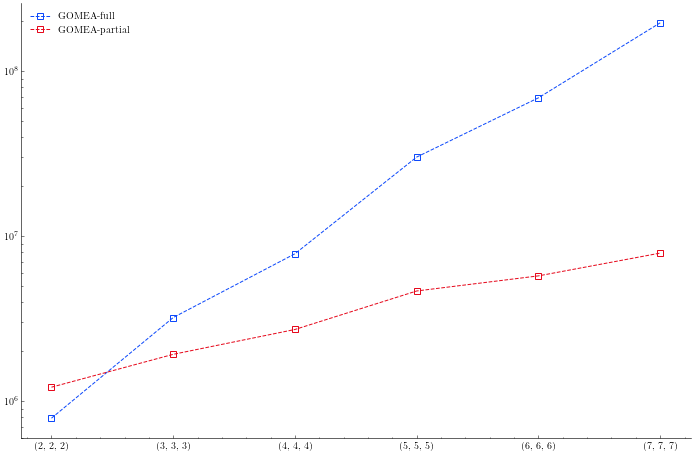

In [55]:
plt.figure(figsize=(12,8))
plt.plot(results["GOMEA"].values(), '--s', markerfacecolor='none', label="GOMEA-full")
plt.plot(results["GOMEA-partial"].values(),  '--s', markerfacecolor='none', label="GOMEA-partial")
plt.xticks([i for i in range(len(order))], order)
plt.yscale("log")
plt.legend()

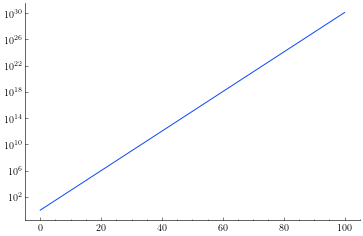

In [54]:
x = np.linspace(0, 100, 1000)
y = 2 ** x
plt.plot(x, y)
plt.yscale("log")